In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16,10

In [3]:
#Read the files
train = pd.read_csv("Train_SU63ISt.csv", parse_dates=['Datetime'], infer_datetime_format = True)

In [4]:
test = pd.read_csv("Test_0qrQsBZ.csv", parse_dates=['Datetime'], infer_datetime_format = True)

In [5]:
#making copy of test and train
train_copy = train.copy()
test_copy = test.copy()

In [6]:
train_copy.shape

(18288, 3)

In [7]:
test_copy.shape

(5112, 2)

In [8]:
test_copy.head(10)

,ID,Datetime
0,18288,2014-09-26 00:00:00
1,18289,2014-09-26 01:00:00
2,18290,2014-09-26 02:00:00
3,18291,2014-09-26 03:00:00
4,18292,2014-09-26 04:00:00
5,18293,2014-09-26 05:00:00
6,18294,2014-09-26 06:00:00
7,18295,2014-09-26 07:00:00
8,18296,2014-09-26 08:00:00
9,18297,2014-09-26 09:00:00


In [9]:
train.head()

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2


In [10]:
for i in (train, test, test_copy, train_copy):
    i['Year']=i.Datetime.dt.year 
    i['Month']=i.Datetime.dt.month 
    i['Day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

In [11]:
for i in (test_copy, train_copy):
    i['DayofWeek']=i.Datetime.dt.dayofweek

In [12]:
def checkweekend(each):
    if each.dayofweek == 5 or each.dayofweek == 6:
        return 1
    else:
        return 0

train_copy['weekend'] = train_copy['Datetime'].apply(checkweekend)


In [13]:
train_copy.head(10)

,ID,Datetime,Count,Year,Month,Day,Hour,DayofWeek,weekend
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,1
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,1
5,5,2012-08-25 05:00:00,2,2012,8,25,5,5,1
6,6,2012-08-25 06:00:00,2,2012,8,25,6,5,1
7,7,2012-08-25 07:00:00,2,2012,8,25,7,5,1
8,8,2012-08-25 08:00:00,6,2012,8,25,8,5,1
9,9,2012-08-25 09:00:00,2,2012,8,25,9,5,1


In [14]:
train_copy=train_copy.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis.
train_copy.index = train_copy['Datetime']

In [15]:
test_copy=test_copy.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis.
test_copy.index = test_copy['Datetime']

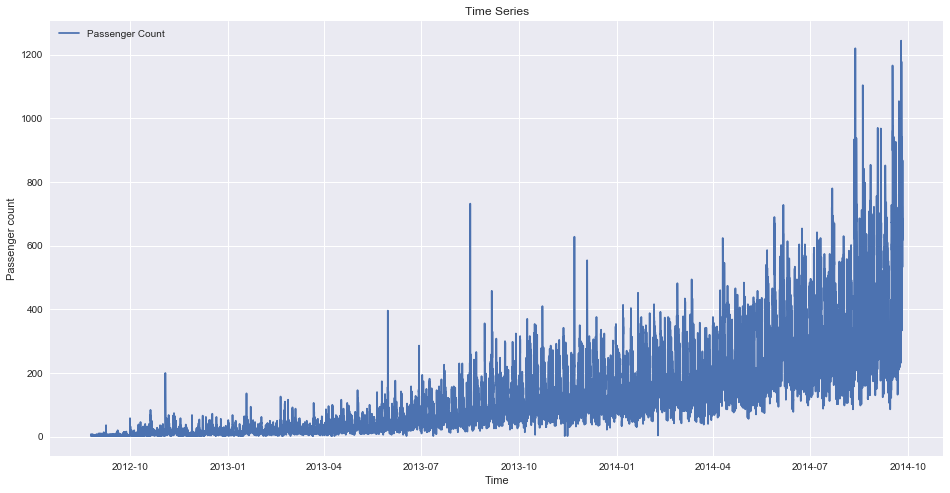

In [16]:
ts = train_copy['Count']
plt.figure(figsize=(16,8))
plt.plot(ts, label='Passenger Count')
plt.title('Time Series')
plt.xlabel("Time")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

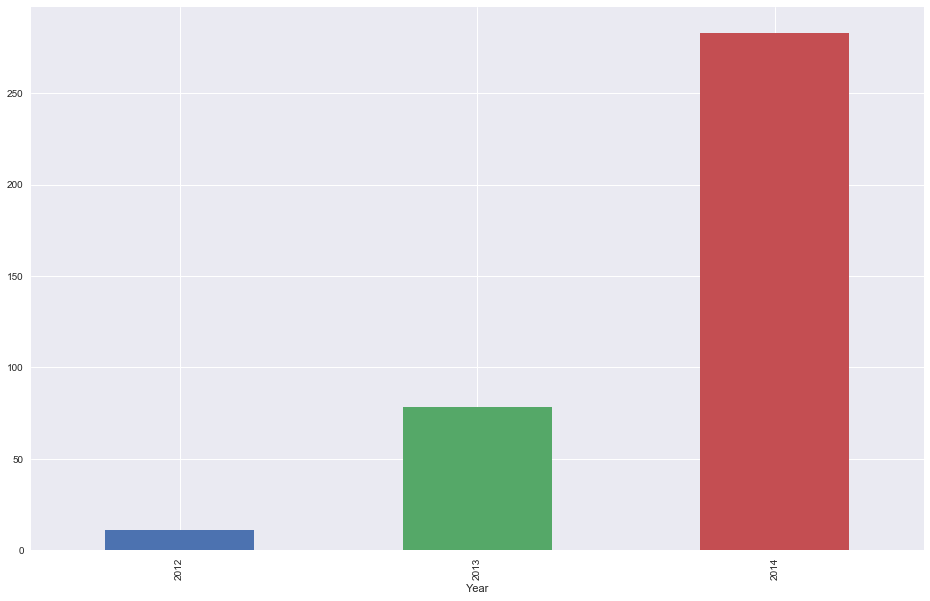

In [17]:
train_copy.groupby('Year')['Count'].mean().plot.bar()
plt.show()

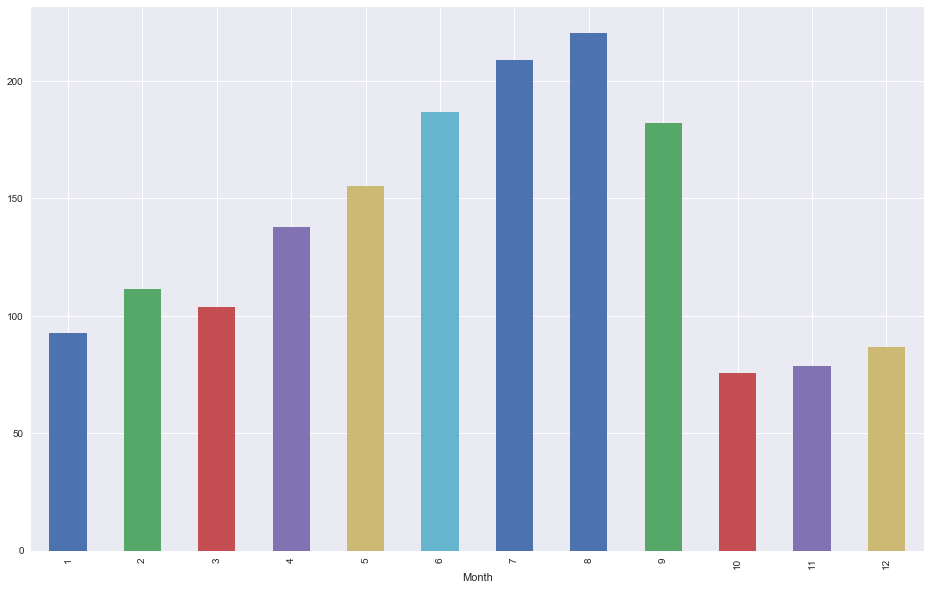

In [18]:
train_copy.groupby('Month')['Count'].mean().plot.bar()
plt.show()

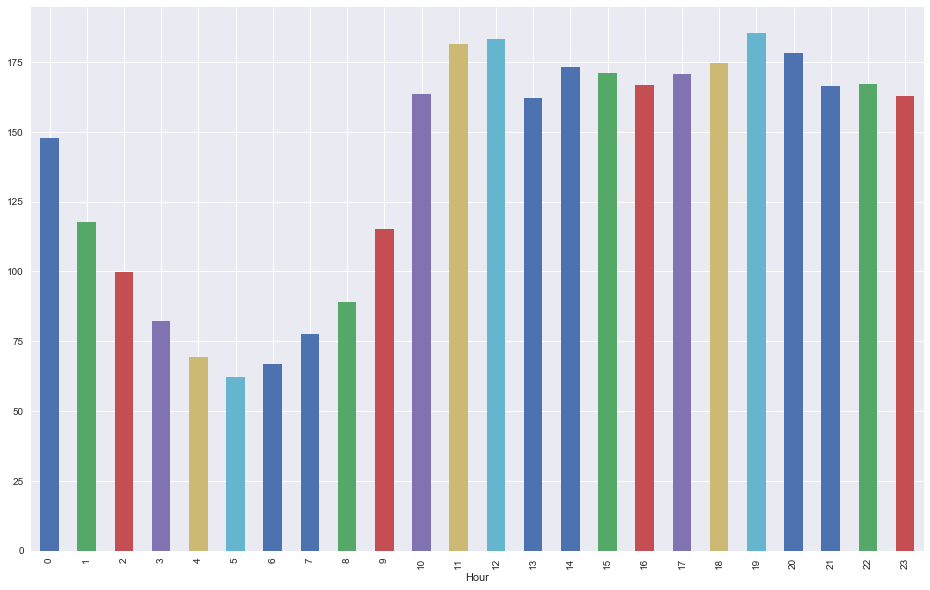

In [19]:
train_copy.groupby('Hour')['Count'].mean().plot.bar()
plt.show()

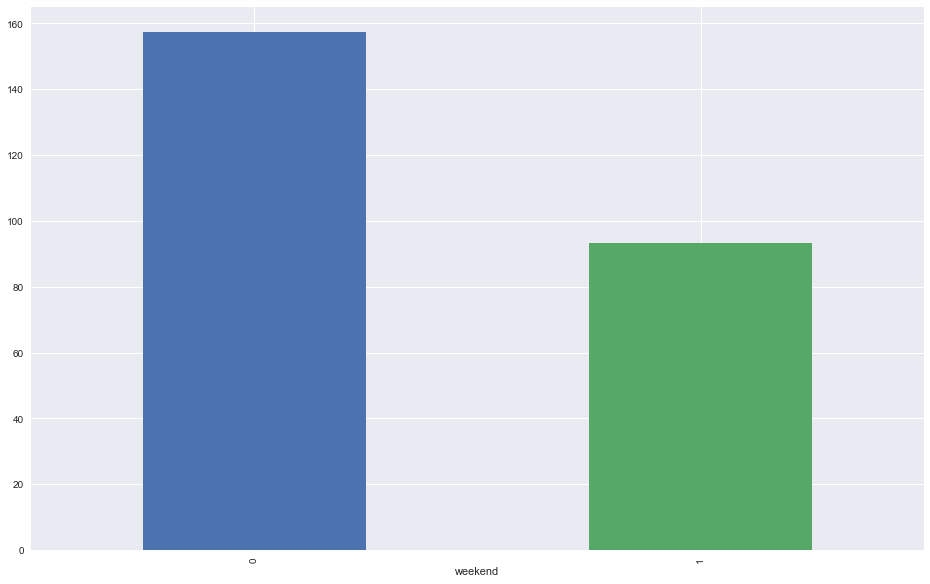

In [20]:
train_copy.groupby('weekend')['Count'].mean().plot.bar()
plt.show()

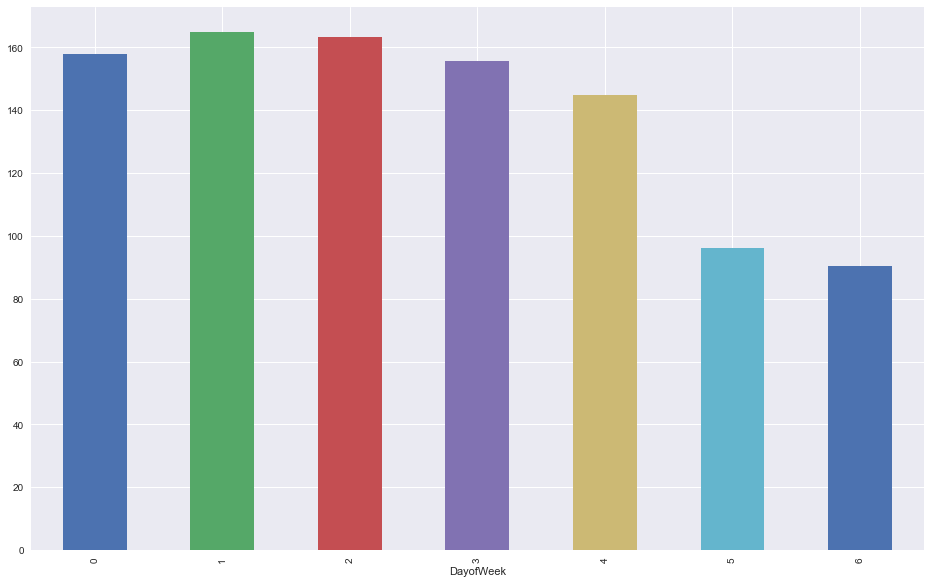

In [21]:
train_copy.groupby('DayofWeek')['Count'].mean().plot.bar()
plt.show()

In [22]:
# Resampling and grouping the data
# Hourly time series
hourly = train_copy.resample('H').mean()

# Converting to daily mean
train_daily = train_copy.resample('D').mean()

# Converting to daily mean
test_daily = test_copy.resample('D').mean()

# Converting to weekly mean
weekly = train_copy.resample('W').mean()

# Converting to monthly mean
monthly = train_copy.resample('M').mean()

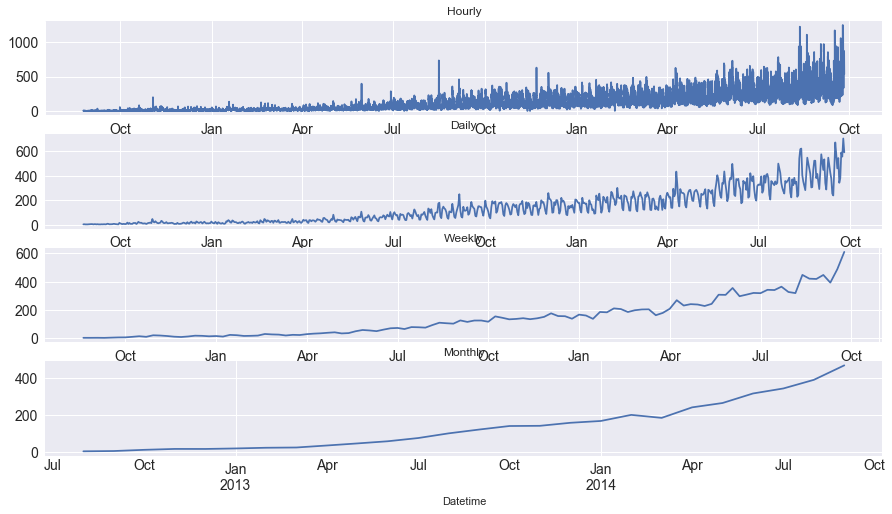

In [23]:
fig, axs = plt.subplots(4,1)

hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0])
train_daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3])

plt.show()

In [24]:
# Split train into trainset and validation set -time based validation
Train=train_daily.ix['2012-08-25':'2014-06-24']
Valid=train_daily.ix['2014-06-25':'2014-09-25']

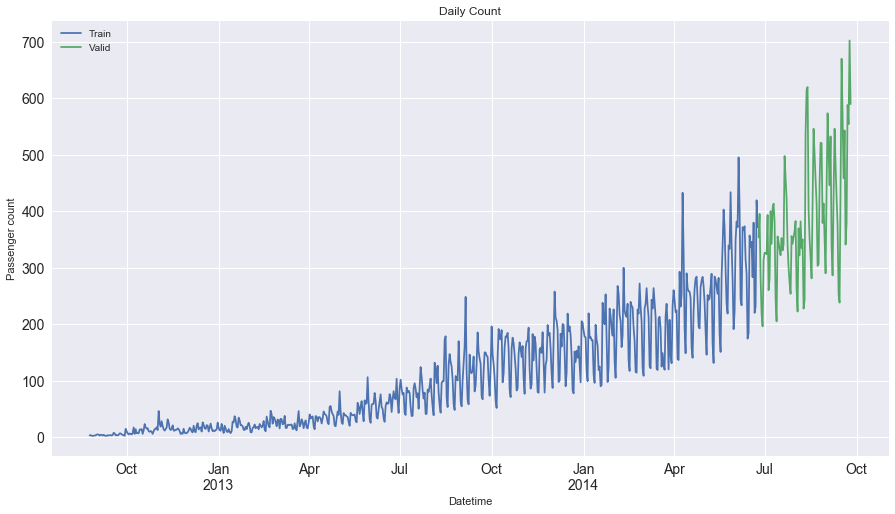

In [25]:
Train.Count.plot(figsize=(15,8), title= 'Daily Count', fontsize=14, label='Train')
Valid.Count.plot(figsize=(15,8), title= 'Daily Count', fontsize=14, label='Valid')
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

# Check for Stationary

In [26]:
def checkStationarity(ts):
    print('Results of Dickey-Fuller Test:')
    fuller = adfuller(ts, autolag='AIC') # AIC metric
    output = pd.Series(fuller[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in fuller[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
checkStationarity(ts)    

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


# Modeling techniques

# i) Naive Approach

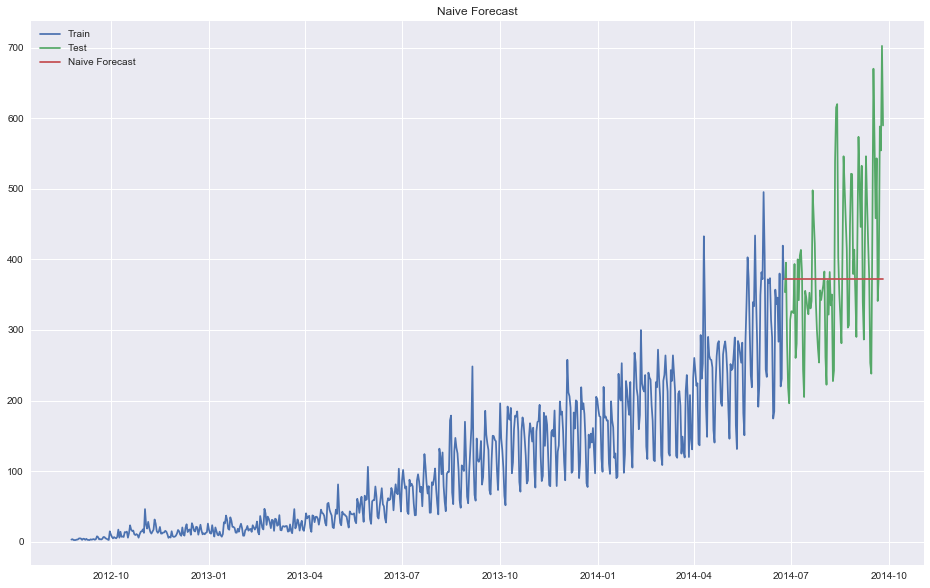

In [27]:
a = np.asarray(Train['Count'])
y_hat = Valid
y_hat['naive']= a[len(a)-1]
plt.plot(Train.index, Train['Count'], label='Train')
plt.plot(Valid.index,Valid['Count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()


In [28]:
rms_naive = sqrt(mean_squared_error(Valid.Count, y_hat['naive']))
print(rms_naive)

111.79050467496724


# ii) Moving Average

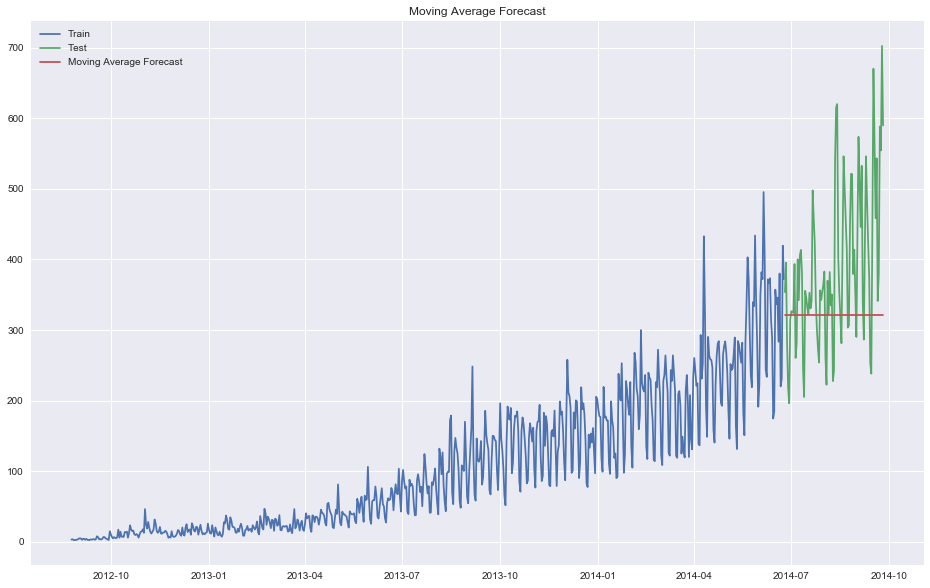

In [29]:
y_hat = Valid
y_hat['moving_avg'] = Train['Count'].rolling(30).mean().iloc[-1]
plt.plot(Train.index, Train['Count'], label='Train')
plt.plot(Valid.index,Valid['Count'], label='Test')
plt.plot(y_hat.index,y_hat['moving_avg'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.title("Moving Average Forecast")
plt.show()


In [30]:
rms_moving_avg = sqrt(mean_squared_error(Valid.Count, y_hat['moving_avg']))
print(rms_moving_avg)

129.6495809983456


# iii) Simple Exponential Smoothing

This technique works on the principle of attaching higher weights to more recent observations than to the observations that are at distant.Forecasts are calculated using weighted averages where the weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

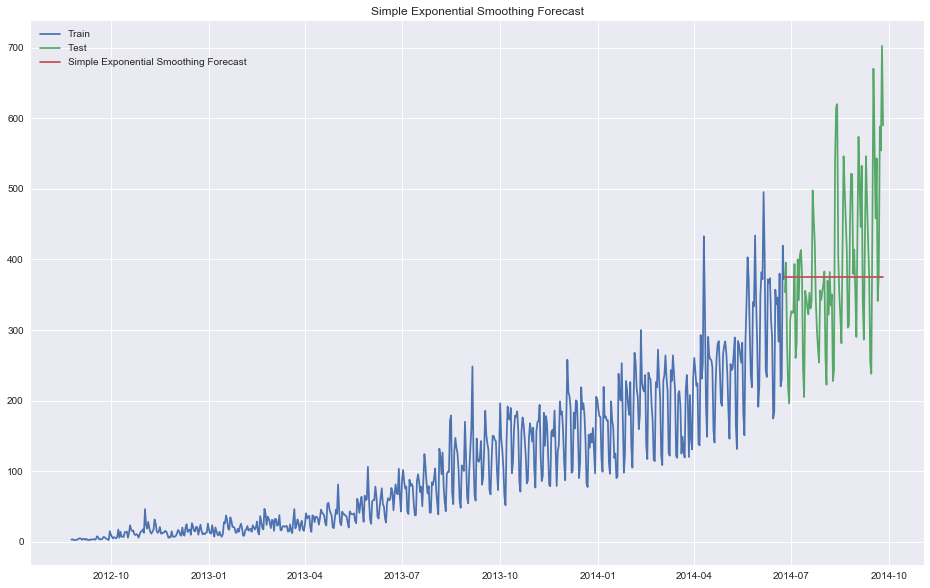

In [31]:
y_hat = Valid
fit_ses = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.9,optimized=False)
y_hat['simple_exp_sm'] = fit_ses.forecast(len(Valid))
plt.plot(Train.index, Train['Count'], label='Train')
plt.plot(Valid.index,Valid['Count'], label='Test')
plt.plot(y_hat.index,y_hat['simple_exp_sm'], label='Simple Exponential Smoothing Forecast')
plt.legend(loc='best')
plt.title("Simple Exponential Smoothing Forecast")
plt.show()


In [32]:
rms_simple_exp_sm = sqrt(mean_squared_error(Valid.Count, y_hat['simple_exp_sm']))
print(rms_simple_exp_sm) # 113.4 112.1 111.5 111.4

111.39025863928183


# iv) Holt’s Linear Trend Model

Each Time series dataset can be decomposed into it’s componenets which are Trend, Seasonality and Residual. Any dataset that follows a trend can use Holt’s linear trend method for forecasting.
A method that takes into account the trend of the dataset is called Holt’s Linear Trend method.

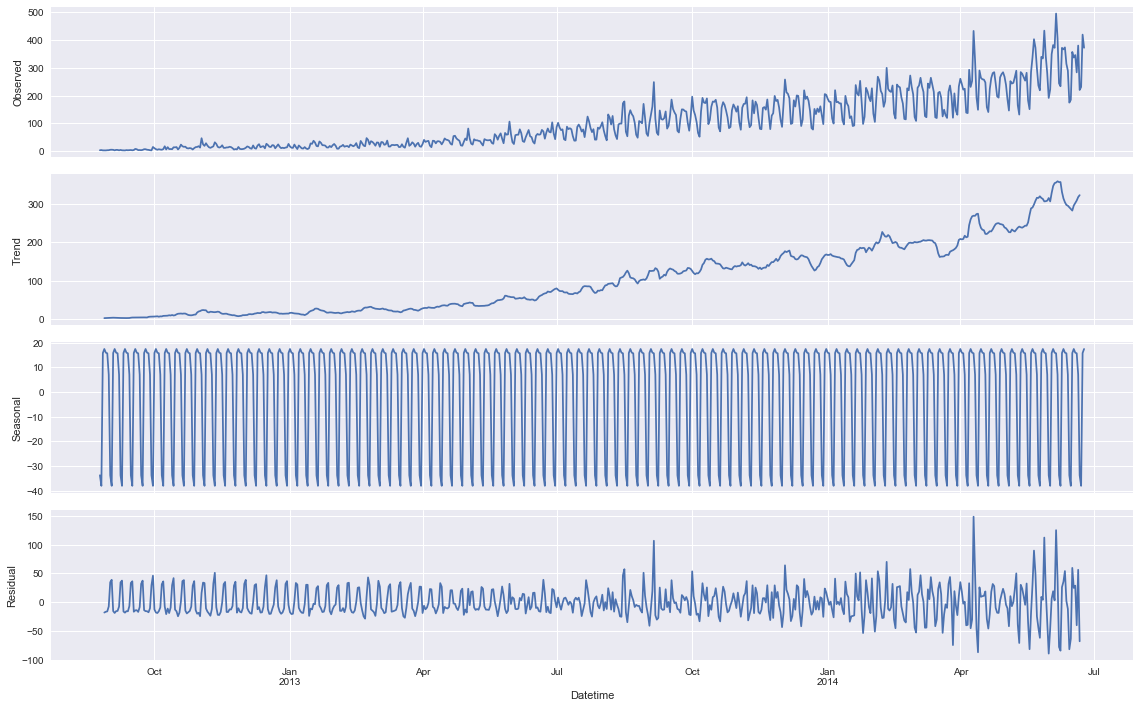

In [33]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train.Count).plot()
result = sm.tsa.stattools.adfuller(Train.Count)
plt.show()

We can see from the graphs obtained that this dataset follows an increasing trend. Hence we can use Holt’s linear trend to forecast the future values.

In [34]:
x = np.arange(0.1,1,0.1)
rms_Holt_linear=[]
y_hat = Valid
for i in x:
    for j in x:        
        fit = Holt(np.asarray(Train['Count'])).fit(smoothing_level = i,smoothing_slope = j)
        y_hat['Holt_linear'] = fit.forecast(len(Valid))
        rms = sqrt(mean_squared_error(Valid.Count, y_hat['Holt_linear']))
        rms_Holt_linear.append([i,j,np.round(rms)])
a_min = min(x[2] for x in rms_Holt_linear)
[(i[0],i[1],a_min) for i in rms_Holt_linear if i[2]==a_min]

[(0.2, 0.1, 107.0)]

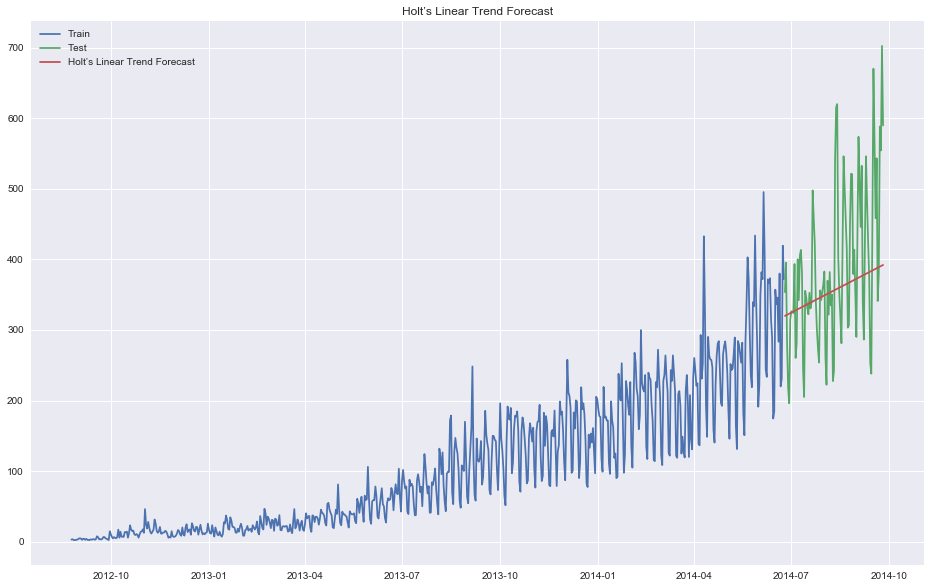

In [35]:
fit = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.2,smoothing_slope = 0.1)
y_hat['Holt_linear'] = fit.forecast(len(Valid))
plt.plot(Train.index, Train['Count'], label='Train')
plt.plot(Valid.index,Valid['Count'], label='Test')
plt.plot(y_hat.index,y_hat['Holt_linear'], label='Holt’s Linear Trend Forecast')
plt.legend(loc='best')
plt.title("Holt’s Linear Trend Forecast")
plt.show()


# v) Holt's Winter Method

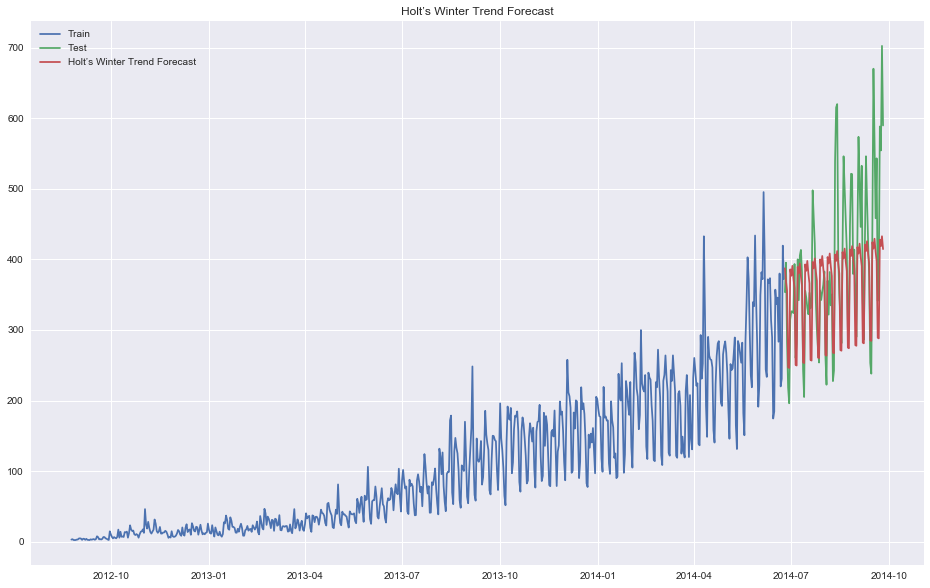

In [36]:
y_hat = Valid
fit = ExponentialSmoothing(np.asarray(Train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat['Holt_Winter'] = fit.forecast(len(Valid))
plt.plot(Train.index, Train['Count'], label='Train')
plt.plot(Valid.index,Valid['Count'], label='Test')
plt.plot(y_hat.index,y_hat['Holt_Winter'], label='Holt’s Winter Trend Forecast')
plt.legend(loc='best')
plt.title("Holt’s Winter Trend Forecast")
plt.show()


In [37]:
rms_holt_winter = sqrt(mean_squared_error(Valid.Count, y_hat['Holt_Winter']))
print(rms_holt_winter) 

82.37467736825413


In [38]:
t = Train
t.head()  #(18288, 7)
t = t.drop(['DayofWeek','Year','Month','Day','Hour','weekend'],1)
#t= t.drop('Datetime',1)

In [39]:
ts = t['Count']
ts.head()

Datetime
2012-08-25    3.166667
2012-08-26    3.666667
2012-08-27    2.583333
2012-08-28    2.416667
2012-08-29    2.500000
Freq: D, Name: Count, dtype: float64

In [40]:
lag_acf = acf(ts, nlags=20)
lag_pacf = pacf(ts, nlags=20, method='ols')

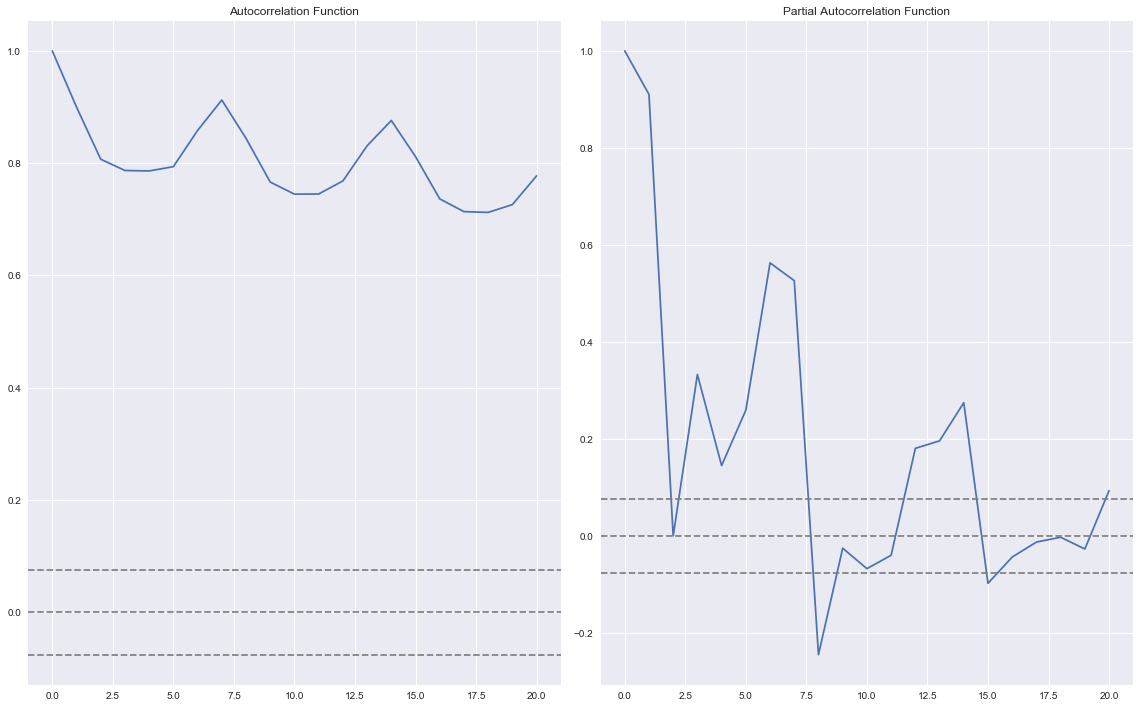

In [41]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show() #p=2 q=2 d=0

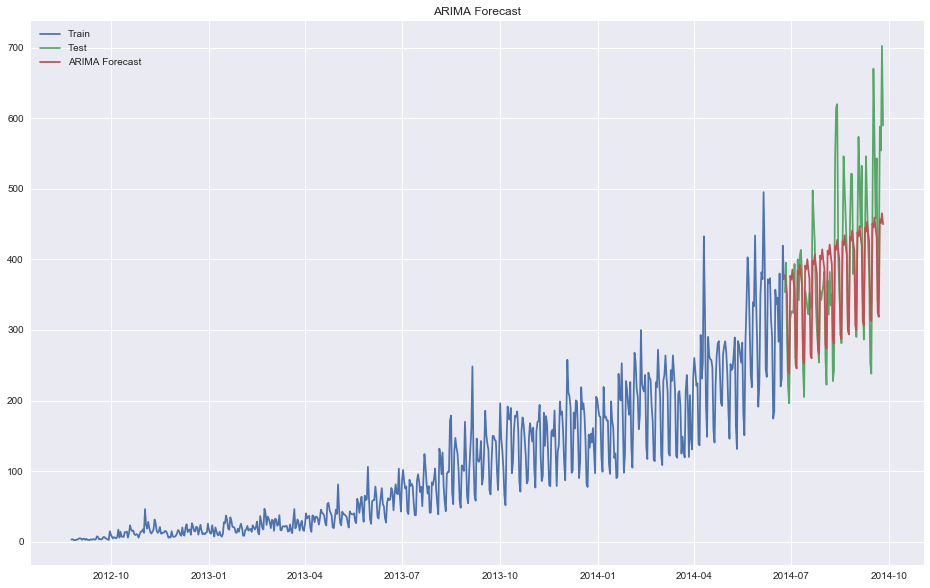

In [42]:
y_hat = Valid
fit = sm.tsa.statespace.SARIMAX(Train.Count, order=(2, 0, 2),seasonal_order=(0,1,1,7)).fit()
y_hat['SARIMA'] = fit.predict(start="2014-06-25", end="2014-09-25", dynamic=True)
plt.plot(Train.index, Train['Count'], label='Train')
plt.plot(Valid.index,Valid['Count'], label='Test')
plt.plot(y_hat.index,y_hat['SARIMA'], label='ARIMA Forecast')
plt.legend(loc='best')
plt.title("ARIMA Forecast")
plt.show()

In [43]:
rms_ARIMA = sqrt(mean_squared_error(Valid.Count, y_hat['SARIMA']))
print(rms_ARIMA) 

72.86792157910652


In [44]:
results = [rms_naive, rms_moving_avg, rms_simple_exp_sm, a_min, rms_holt_winter, rms_ARIMA]
df = pd.DataFrame(results[0:7], 
                  index=['Naive Method','Moving average','Simple Exponential Smoothing','Holts Linear Trend','Holts Winter','ARIMA'])
df.columns = ['RMSE']
df

,RMSE
Naive Method,111.790505
Moving average,129.649581
Simple Exponential Smoothing,111.390259
Holts Linear Trend,107.000000
Holts Winter,82.374677
ARIMA,72.867922


So the best model of all the above is ARIMA forecast model. Using this model to predict the values on test data behaves as below:

C:\Users\jadha\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


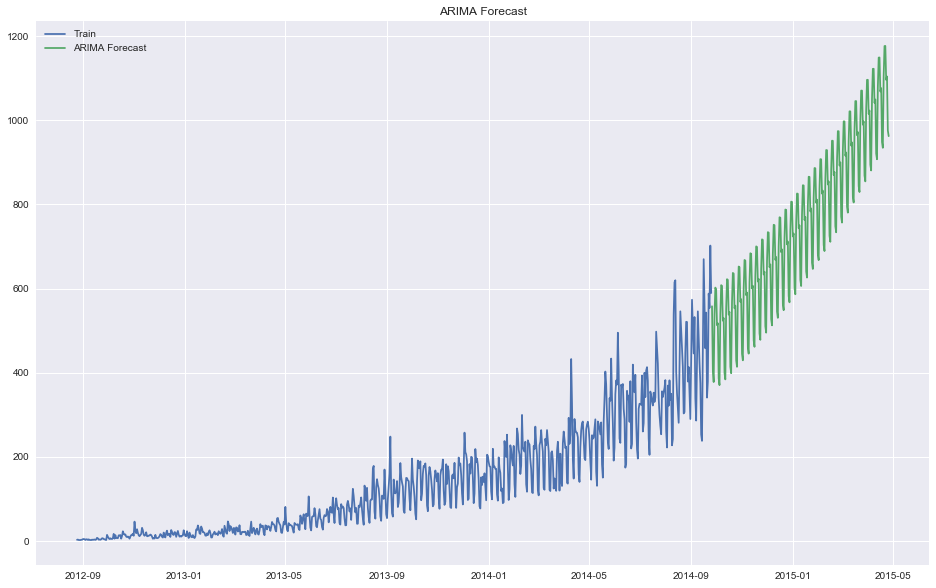

In [101]:
y_hat = test_daily
fit = sm.tsa.statespace.SARIMAX(train_daily['Count'], order=(2, 0, 2),seasonal_order=(0,1,1,7),enforce_stationarity=False, enforce_invertibility=False).fit()
y_hat['SARIMA'] = fit.predict(start="2014-09-26", end="2015-04-26", dynamic=True)
plt.plot(train_daily.index, train_daily['Count'], label='Train')
#plt.plot(Valid.index,Valid['Count'], label='Test')
plt.plot(y_hat.index,y_hat['SARIMA'], label='ARIMA Forecast')
plt.legend(loc='best')
plt.title("ARIMA Forecast")
plt.show()

In [102]:
y_hat.tail(10000)

,Year,Month,Day,Hour,DayofWeek,SARIMA
Datetime,,,,,,
2014-09-26,2014.0,9.0,26.0,11.5,4.0,558.101885
2014-09-27,2014.0,9.0,27.0,11.5,5.0,406.831891
2014-09-28,2014.0,9.0,28.0,11.5,6.0,378.017922
2014-09-29,2014.0,9.0,29.0,11.5,0.0,538.737383
2014-09-30,2014.0,9.0,30.0,11.5,1.0,602.503619
2014-10-01,2014.0,10.0,1.0,11.5,2.0,597.629363
2014-10-02,2014.0,10.0,2.0,11.5,3.0,512.903515
2014-10-03,2014.0,10.0,3.0,11.5,4.0,517.747549
2014-10-04,2014.0,10.0,4.0,11.5,5.0,386.744490


In [103]:
#df.reset_index(drop=True, inplace=True)
#df.insert(0, 'ID', range(1, 214))
df.rename(columns={'SARIMA':'Count'}, inplace=True)
#df = pd.DataFrame()
df.to_csv('Submission.csv', index=False)